In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random

In [2]:
from datasets import load_dataset

dataset = load_dataset("Ransaka/youtube_thumbnail_small")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'tag', 'title'],
        num_rows: 1389
    })
})

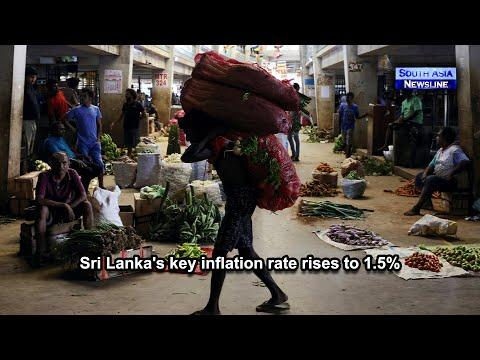

In [4]:
dataset['train'][88]['image']

In [5]:
dataset['train'][88]['title']

'Sri Lanka&#39;s key inflation rate rises to 1.5%'

In [6]:
dataset['train'][88]['image'].size

(480, 360)

In [7]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),  # (480, 360)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(out_channels, 2 * out_channels, 3, padding=1, stride=2),  # (240, 180)
            act_fn,
            nn.Conv2d(2 * out_channels, 2 * out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2 * out_channels, 4 * out_channels, 3, padding=1, stride=2),  # (120, 90)
            act_fn,
            nn.Conv2d(4 * out_channels, 4 * out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(4 * out_channels * 120 * 90, latent_dim),
            act_fn
        )

    def forward(self, x):
        x = x.view(-1, 3, 480, 360)
        output = self.net(x)
        return output


class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()

        self.out_channels = out_channels

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * out_channels * 120 * 90),
            act_fn
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(4 * out_channels, 4 * out_channels, 3, padding=1),  # (120, 90)
            act_fn,
            nn.ConvTranspose2d(4 * out_channels, 2 * out_channels, 3, padding=1,
                               stride=2, output_padding=1),  # (240, 180)
            act_fn,
            nn.ConvTranspose2d(2 * out_channels, 2 * out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(2 * out_channels, out_channels, 3, padding=1,
                               stride=2, output_padding=1),  # (480, 360)
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 4 * self.out_channels, 120, 90)
        output = self.conv(output)
        return output


class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.encoder.to(device)

        self.decoder = decoder
        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
encoder = Encoder()
decoder = Decoder()
autoencoder = Autoencoder(encoder, decoder)

In [9]:
sample_img = torch.randn(1,3,480, 360, device=device)

In [10]:
sample_output = autoencoder(sample_img)

In [11]:
autoencoder.encoder(sample_img).shape

torch.Size([1, 200])

In [12]:
sample_output.shape

torch.Size([1, 3, 480, 360])

In [13]:
dataset = dataset['train'].train_test_split()

In [14]:
class ThumbnailDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']

        if self.transforms!=None:
            image = self.transforms(image)
        return image

    
training_data = ThumbnailDataset(dataset['train'], transforms=transforms.Compose([transforms.ToTensor(),
                                                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
validation_data = ThumbnailDataset(dataset['train'], transforms=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
# test_data = ThumbnailDataset(test_images, transforms=transforms.Compose([transforms.ToTensor(),
#                                                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [15]:
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)
    # test_loader = DataLoader(test_set, 10)

    #  setting convnet to training mode
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #------------
      #  TRAINING
      #------------
      print('training...')
      for images in tqdm(train_loader):
        #  zeroing gradients
        self.optimizer.zero_grad()
        #  sending images to device
        images = images.to(device)
        #  reconstructing images
        output = self.network(images)
        #  computing loss
        loss = loss_function(output, images.view(-1, 3, 480, 360))
        #  calculating gradients
        loss.backward()
        #  optimizing weights
        self.optimizer.step()

        #--------------
        # LOGGING
        #--------------
        log_dict['training_loss_per_batch'].append(loss.item())

      #--------------
      # VALIDATION
      #--------------
      print('validating...')
      for val_images in tqdm(val_loader):
        with torch.no_grad():
          #  sending validation images to device
          val_images = val_images.to(device)
          #  reconstructing images
          output = self.network(val_images)
          #  computing validation loss
          val_loss = loss_function(output, val_images.view(-1, 3, 480, 360))

        #--------------
        # LOGGING
        #--------------
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      #--------------
      # VISUALISATION
      #--------------
      print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

#       for test_images in test_loader:
#         #  sending test images to device
#         test_images = test_images.to(device)
#         with torch.no_grad():
#           #  reconstructing test images
#           reconstructed_imgs = self.network(test_images)
#         #  sending reconstructed and images to cpu to allow for visualization
#         reconstructed_imgs = reconstructed_imgs.cpu()
#         test_images = test_images.cpu()

#         #  visualisation
#         imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], 
#                           dim=1).flatten(0,1)
#         grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
#         grid = grid.permute(1, 2, 0)
#         plt.figure(dpi=170)
#         plt.title('Original/Reconstructed')
#         plt.imshow(grid)
#         log_dict['visualizations'].append(grid)
#         plt.axis('off')
#         plt.show()
      
    return log_dict

  def autoencode(self, x):
    return self.network(x)

  def encode(self, x):
    encoder = self.network.encoder
    return encoder(x)
  
  def decode(self, x):
    decoder = self.network.decoder
    return decoder(x)

In [16]:
model = ConvolutionalAutoencoder(Autoencoder(Encoder(), Decoder()))

log_dict = model.train(nn.MSELoss(), epochs=10, batch_size=64, 
                       training_set=training_data, validation_set=validation_data)

Epoch 1/10
training...


  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 